# Time Series Data Exploration

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.ion()

import acquire
import prepare

Plotting defaults:

In [2]:
plt.rc('figure', figsize=(13, 6))
plt.rc('axes.spines', top=False, right=False)
plt.rc('font', size=13)

Historical San Antonio weather data.

In [3]:
# T(°F) = T(K) × 9/5 - 459.67
def to_fahrenheit(k):
    return k * 9/5 - 459.67

url = "https://gist.githubusercontent.com/ryanorsinger/0ec766c66f4089bdcbc1d4fb294a3394/raw/197c1f0d7b55a45f29437811bc73d9c4ef8af647/sa_temps.csv"
s = pd.read_csv(url, index_col='datetime', parse_dates=True).temp
s = s.dropna()
s = to_fahrenheit(s)
print('Data ranges from {} to {}'.format(s.index.min(), s.index.max()))
s.head()

Data ranges from 2012-10-01 13:00:00 to 2017-11-30 00:00:00


datetime
2012-10-01 13:00:00    61.052000
2012-10-01 14:00:00    61.076568
2012-10-01 15:00:00    61.139294
2012-10-01 16:00:00    61.202020
2012-10-01 17:00:00    61.264747
Name: temp, dtype: float64

## Train Test Split

* Percentage based
* Human-based

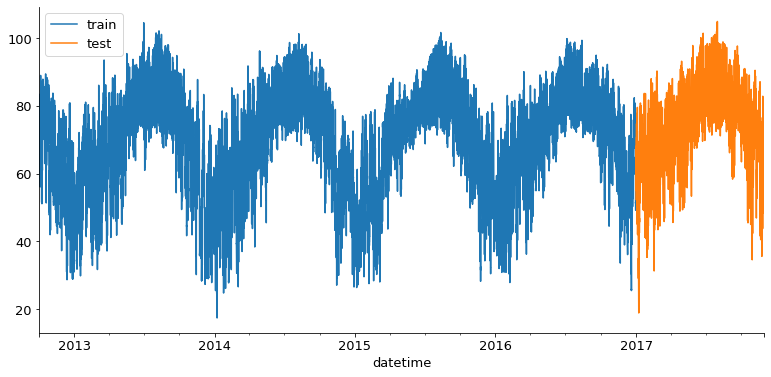

In [4]:
train = s.loc[:'2016']
test = s.loc['2017']

ax = train.plot(label='train')
test.plot(ax=ax, label='test')
plt.legend()

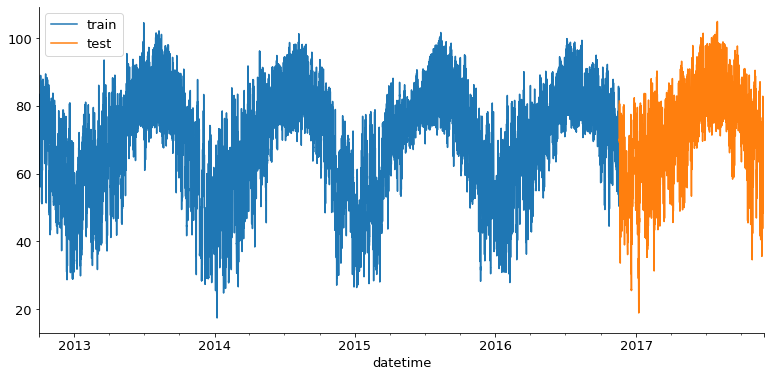

In [5]:
# Percentage
train_size = .80
test_size = .20

train_end_index = round(s.shape[0] * train_size)
train = s.iloc[:train_end_index]
test = s.iloc[train_end_index:]

ax = train.plot(label = 'train')
test.plot(ax = ax, label = 'test')
plt.legend()

In [6]:
s = train.copy()

## How do we visualize time series data?

Line plot with time on the x-axis

In [7]:
s.head()

datetime
2012-10-01 13:00:00    61.052000
2012-10-01 14:00:00    61.076568
2012-10-01 15:00:00    61.139294
2012-10-01 16:00:00    61.202020
2012-10-01 17:00:00    61.264747
Name: temp, dtype: float64

<AxesSubplot:xlabel='datetime'>

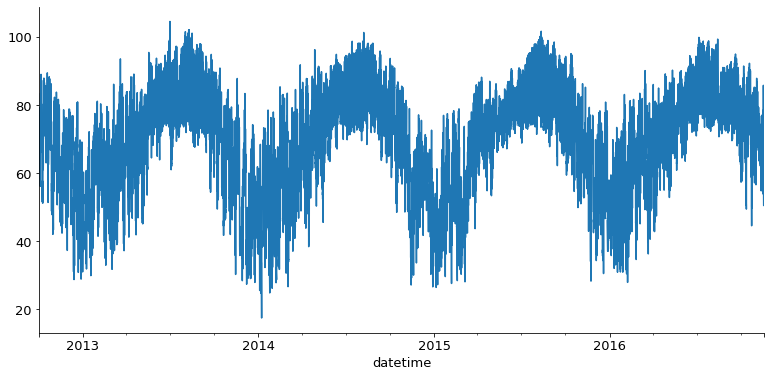

In [8]:
s.plot()

Re-sampling at a longer frequency "smooths" the line

<AxesSubplot:xlabel='datetime'>

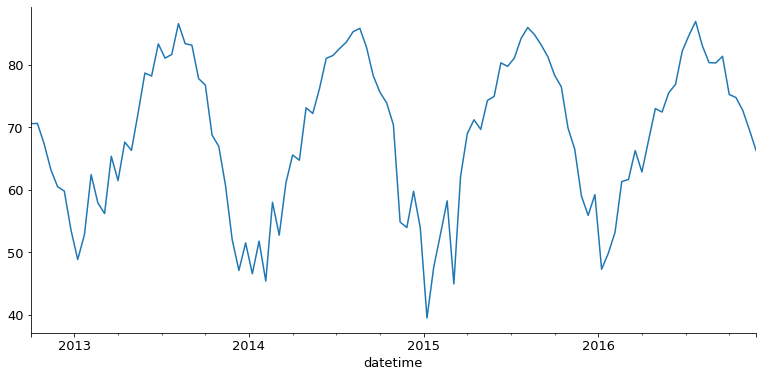

In [9]:
s.resample('2W').mean().plot()

We can combine multiple resampling periods on a single viz:

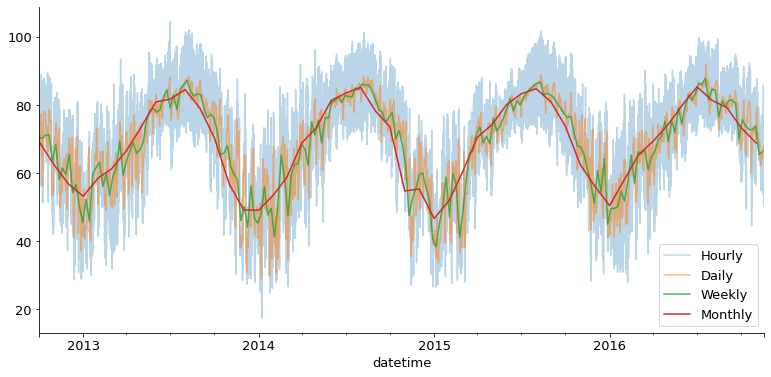

In [10]:
ax = s.plot(alpha=.3, label='Hourly')
s.resample('D').mean().plot(ax=ax, alpha=.5, label='Daily')
s.resample('W').mean().plot(ax=ax, alpha=.8, label='Weekly')
s.resample('M').mean().plot(ax=ax, label='Monthly')
ax.legend()

Treat date components as categorical variables

<div style="padding: 1em 2em; border: 1px solid navy; border-radius: 5px;">
    <p><strong>Aside: Month and Weekday Ordering</strong></p>
    <p>By default, matplotlib/pandas will sort months and weekdays alphabetically, which is usually not what we want.</p>
    <p>There are several ways to work around this:</p>
    <ul>
        <li>Use pandas <a href="https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html">category type</a>(<code>pd.Categorical</code>)</li>
        <li>Just use the month (1-12) number or weekday number (1-7)</li>
        <li>Instead of using just the month or weekday, use a leading number and then the name (e.g. 1-Jan, 2-Feb)</li>
        <li>Use a combination of the techniques above, and then re-index the resulting pandas object with more human friendly names</li>
        <li>Use a combination of the techniques above, and then manually adjust the labels with matplotlib</li>
    </ul>
</div>

<AxesSubplot:xlabel='datetime'>

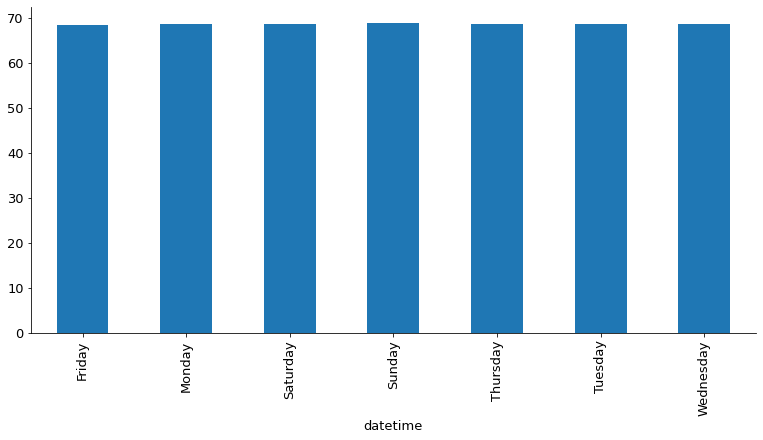

In [11]:
s.groupby(s.index.day_name()).mean().plot.bar()

<AxesSubplot:xlabel='datetime'>

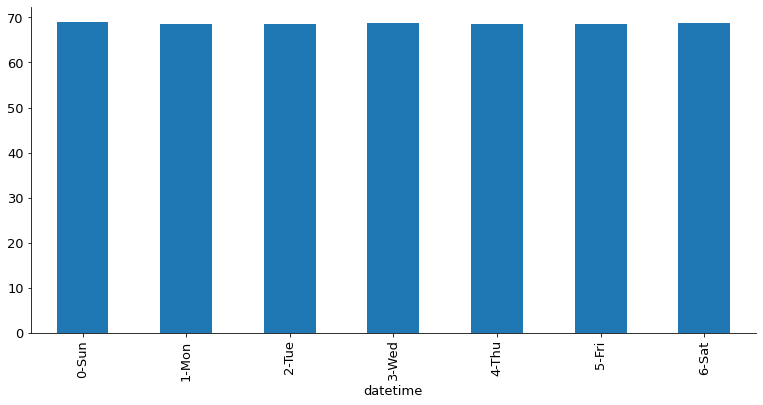

In [12]:
s.groupby(s.index.strftime('%w-%a')).mean().plot.bar()

<AxesSubplot:ylabel='datetime'>

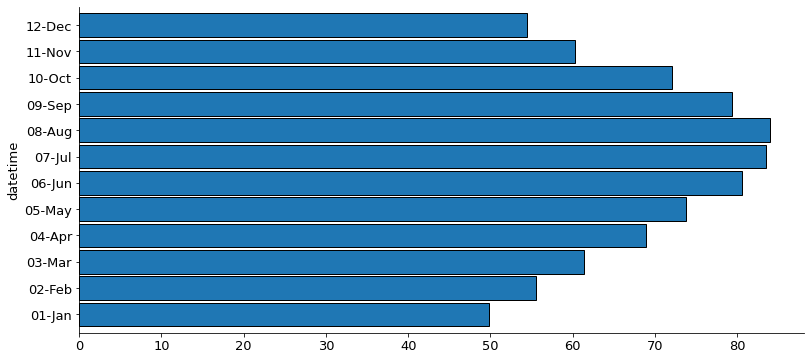

In [13]:
# s.groupby(s.index.month).mean().plot.bar()
# demonstrating one of the above techniques
s.groupby(s.index.strftime('%m-%b')).mean().plot.barh(width=.9, ec='black')

Moving Average

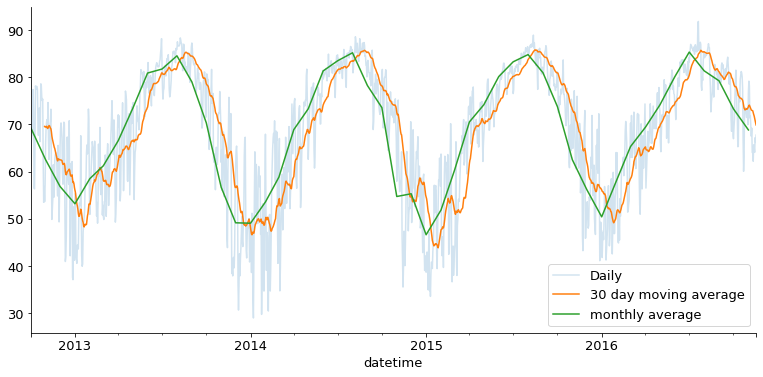

In [14]:
ax = s.resample('D').mean().plot(label='Daily', alpha=.2)
s.resample('D').mean().rolling(30).mean().plot(ax=ax, label='30 day moving average')
s.resample('M').mean().plot(ax=ax, label='monthly average')
ax.legend()

**Differences**

`.diff` let's us take the difference between the current and previous value.

In [15]:
df = pd.DataFrame(dict(x=[1, 2, 5, 0, 12]))
df['x.diff()'] = df.x.diff()
df['x.diff(2)'] = df.x.diff(2)
df

,x,x.diff(),x.diff(2)
0,1,NaN,NaN
1,2,1.0,NaN
2,5,3.0,4.0
3,0,-5.0,-2.0
4,12,12.0,7.0


Notice how the first value (or the first 2 in the case of `.diff(2)`) is NaN because there is no previous value to diff against.

Let's visualize the monthly change in temperature:

<AxesSubplot:xlabel='datetime'>

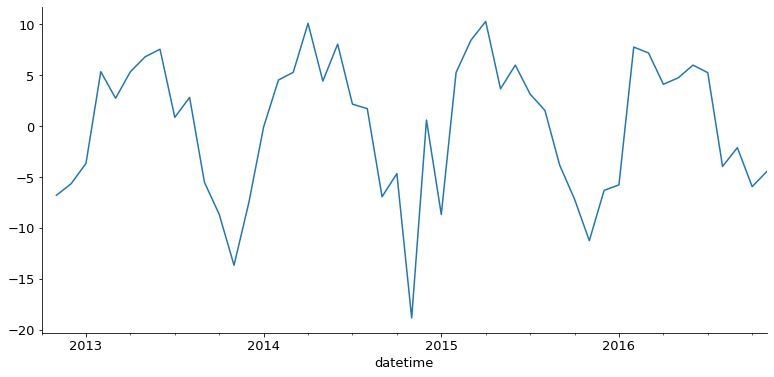

In [16]:
s.resample('M').mean().diff().plot()

Note that this looks pretty similar to plotting the monthly average temperature over time. However, note the units on the y-axis. This is now *change* in temperature from one month to the next.

We could visualize the difference in temperature from each day in the previous year by resampling to the day and using a diff of 365:

<AxesSubplot:xlabel='datetime'>

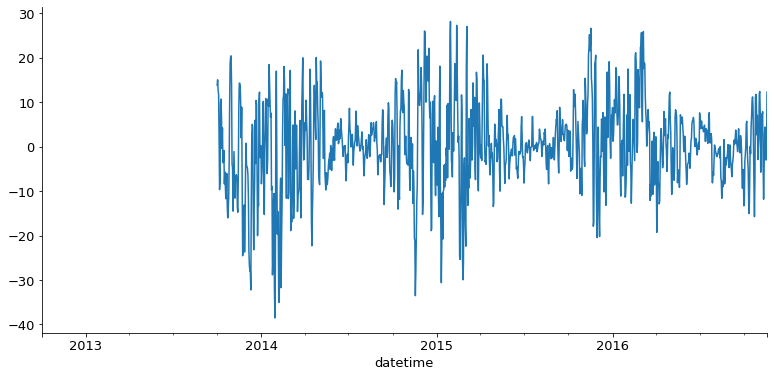

In [17]:
s.resample('D').mean().diff(365).plot()

Or we could look at the difference between each month and the same month the previous year by resampling to the month and taking a diff of 12:

<AxesSubplot:xlabel='datetime'>

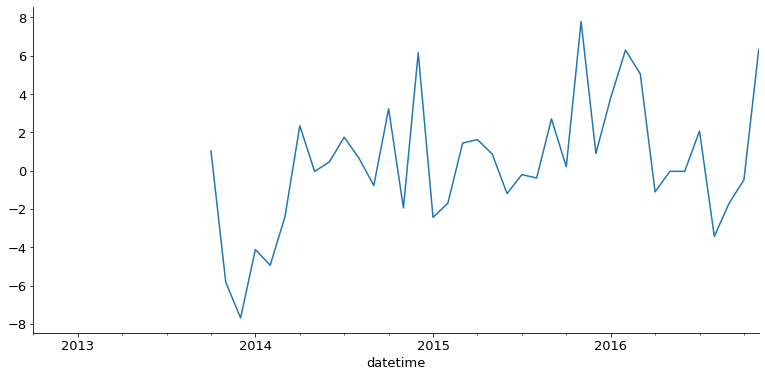

In [18]:
s.resample('M').mean().diff(12).plot()

### Shift

`.shift` is very similar to `.diff`, but `.shift` moves the values up by a certain amount as opposed to taking the difference:

In [19]:
df = pd.DataFrame(dict(x=[1, 2, 5, 0, 12]))
df['x.shift()'] = df.x.shift()
df['x.shift(2)'] = df.x.shift(2)
df

,x,x.shift(),x.shift(2)
0,1,NaN,NaN
1,2,1.0,NaN
2,5,2.0,1.0
3,0,5.0,2.0
4,12,0.0,5.0


We could use `.shift` to overlay the temperature for the same month in hte previous year:

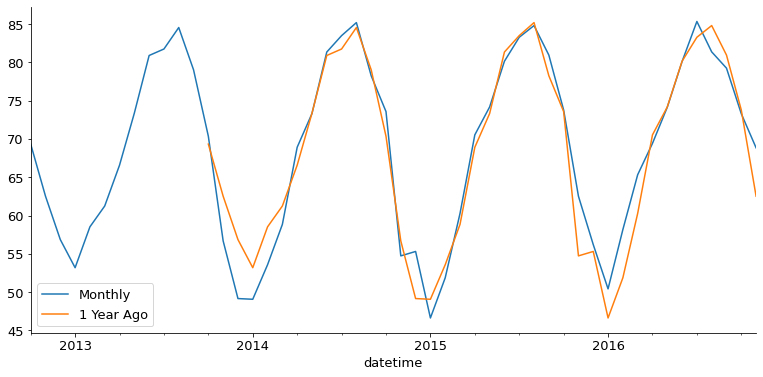

In [20]:
ax = s.resample('M').mean().plot(label='Monthly')
s.resample('M').mean().shift(12).plot(label='1 Year Ago', ax=ax)
ax.legend()

First we resample to the month and then do a shift of 12 to move each data point forward one year.

#### Customizing Ticks

There are a number of ways we can customize datetime axes using matplotlib:

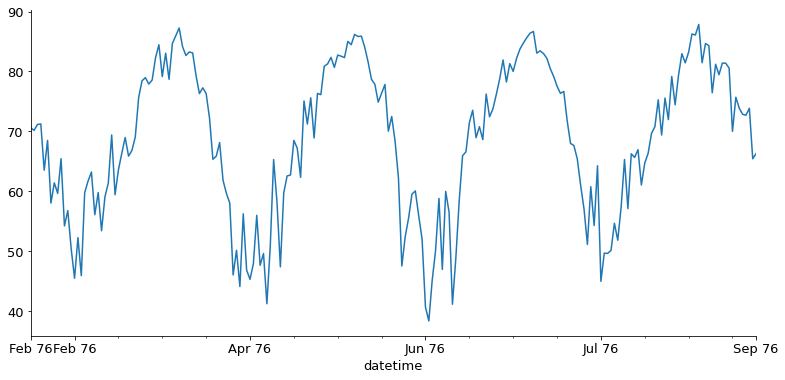

In [21]:
# Using a major formatter:
ax = s.resample('W').mean().plot()
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b %y'))

[Text(0, 0, 'January'),
 Text(1, 0, 'February'),
 Text(2, 0, 'March'),
 Text(3, 0, 'April'),
 Text(4, 0, 'May'),
 Text(5, 0, 'June'),
 Text(6, 0, 'July'),
 Text(7, 0, 'August'),
 Text(8, 0, 'September'),
 Text(9, 0, 'October'),
 Text(10, 0, 'November'),
 Text(11, 0, 'December')]

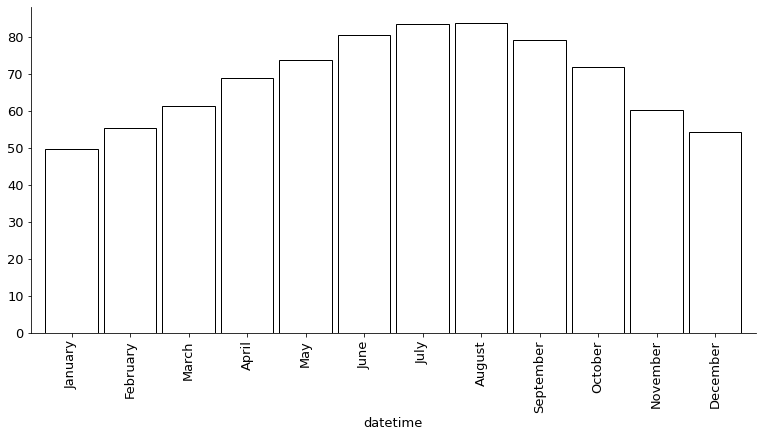

In [22]:
# Here we include the month number when grouping by month so that the months appear in the correct order in our visualization.
ax = s.groupby(s.index.strftime('%m-%B')).mean().plot.bar(width=.9, ec='black', fc='white')
# The next two lines basically "slice off" the number prefix of the month labels.
labels = ax.get_xticklabels()
ax.set_xticklabels([l.get_text()[3:] for l in labels])

## Identifying Seasonality and Trend

- **trend**: long term increase or decrease in the data
- **seasonality**: cyclic pattern of a fixed frequency

### Seasonality

A **lag plot** is a scatter plot of the value at a time against the value at the same time time plus some value, k.

For example, we could plot the correlation between the temperature one day and the temperature the next.

<AxesSubplot:xlabel='t', ylabel='t + 1'>

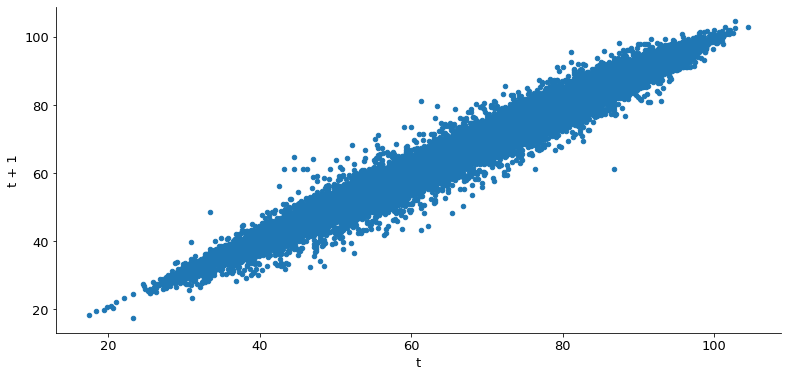

In [23]:
# We concatenate the series with itself shifted by 1 and then make a scatter plot of the two columns
pd.concat([s.rename('t'), s.shift().rename('t + 1')], axis=1).plot.scatter(y='t + 1', x='t')

Each point represents the temperature for one day on the x-axis, and the temperature for the next day on the y-axis.

The correlation between each day and the next day is pretty high.

Maybe less so for a day and the same day next week.

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 7)'>

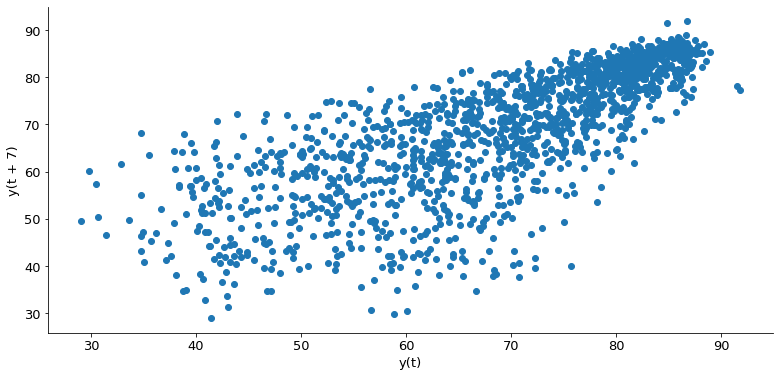

In [24]:
# note here we are using a pandas built-in to make our lag plot
pd.plotting.lag_plot(s.resample('D').mean(), 7)

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

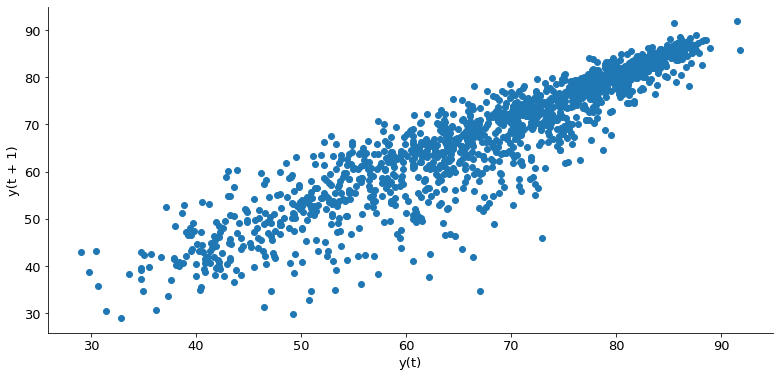

In [25]:
# note here we are using a pandas built-in to make our lag plot
pd.plotting.lag_plot(s.resample('D').mean(), 1)

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

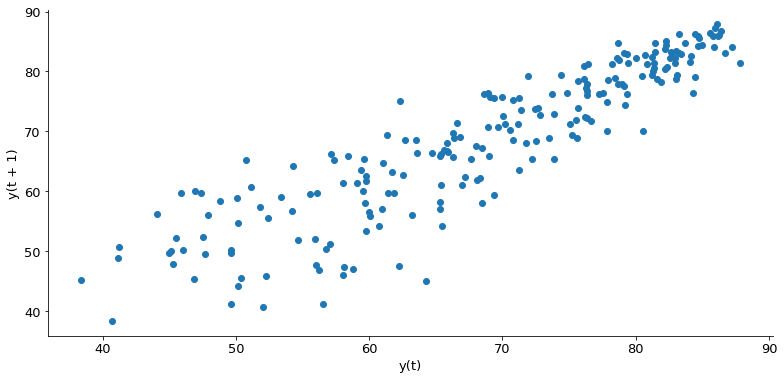

In [26]:
# We could also look at weeks instead of days
pd.plotting.lag_plot(s.resample('W').mean(), 1)

What's the correlation between each day and the same day the next year? Half year?

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 365)'>

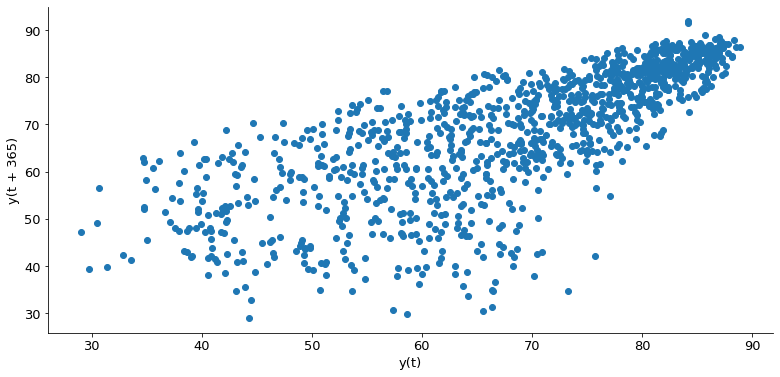

In [27]:
pd.plotting.lag_plot(s.resample('D').mean(), 365)

In [28]:
def autocorrelation(s, lag):
    return pd.concat([s, s.shift(lag)], axis=1).dropna().corr().iloc[0, 1]

In [29]:
autocorrelation(s.resample('D').mean(), 1)

0.9226278828939677

In [30]:
autocorrelation(s.resample('D').mean(), 2)

0.8341163661284547

In [31]:
autocorrelation(s.resample('D').mean(), 3)

0.7921459572641545

This brings us to the concept of **autocorrelation**. Autocorrelation is a series correlation with itself, at various different lag values.

In [32]:
# Here we construct a series with index being each number from 1 to 365, and the values being the
# autocorrelation for that value of lag
autocorr = pd.Series({lag: autocorrelation(s.resample('D').mean(), lag) for lag in range(1, 365)})
autocorr

1      0.922628
2      0.834116
3      0.792146
4      0.783796
5      0.778988
         ...   
360    0.745940
361    0.755020
362    0.758001
363    0.756120
364    0.757591
Length: 364, dtype: float64

<AxesSubplot:>

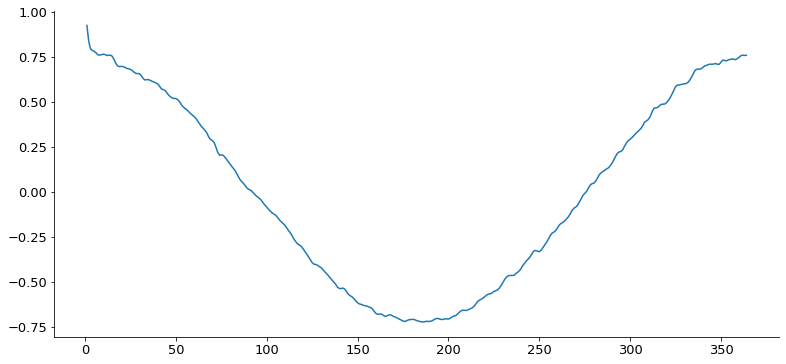

In [33]:
autocorr.plot()

This is a common visualization to use to identify seasonality, and pandas has a built in plotting function for it as well:

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

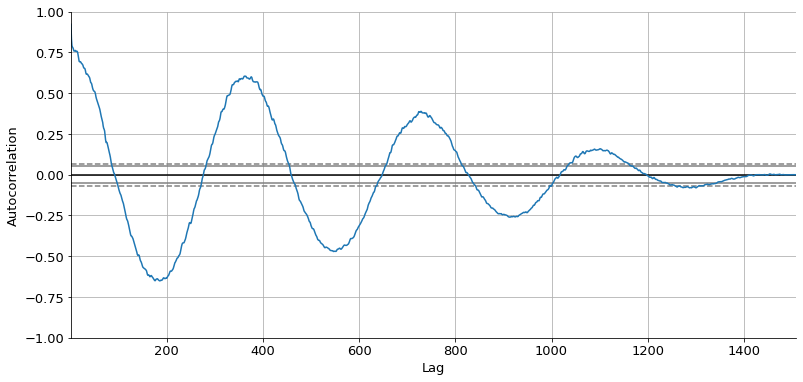

In [34]:
pd.plotting.autocorrelation_plot(s.resample('D').mean())

Note:

- The x axis is the value for lag
- The y axis is the correlation for that value of lag
- peaks indicate where the seasonal pattern repeats (each year / half year)
- decreasing peaks over time mean that correlation between this time this next year is stronger than the correlation between this time 2 years from now
- If the peaks fall within the horizontal lines, the observed pattern could be simply random noise. This is clearly **not** the case in the example above.

Remember, our choice of time units is somewhat arbitrary:

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

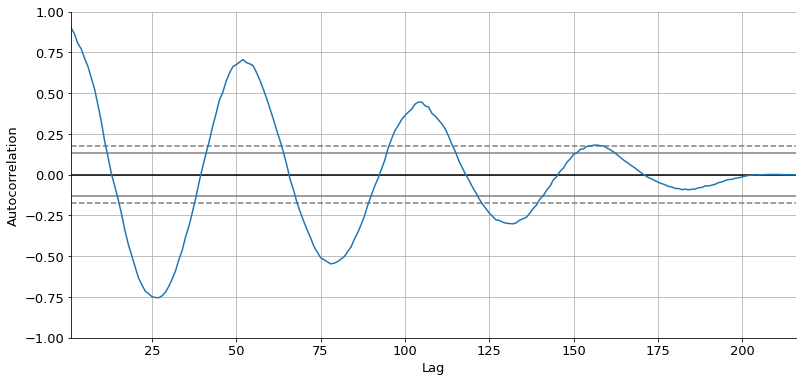

In [35]:
pd.plotting.autocorrelation_plot(s.resample('W').mean())

Notice in this dataset we also have hourly seasonality. Let's take a look at february 2013 as an example:

<AxesSubplot:xlabel='datetime'>

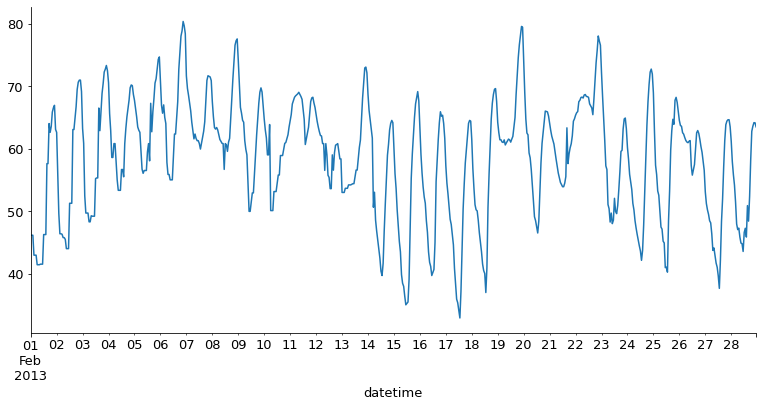

In [36]:
hourly = s['2013-02-01':'2013-02-28'].resample('H').mean()
hourly.plot()

We could view the autocorrelation plot for this hourly data as well:

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

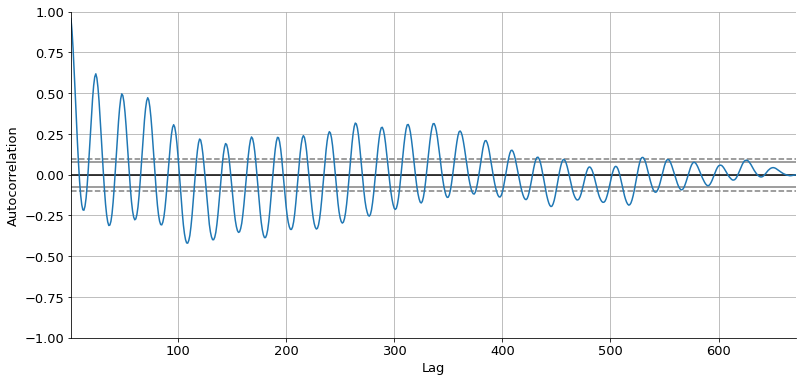

In [37]:
pd.plotting.autocorrelation_plot(hourly)

### Trend

There are several techniques and visualizations we can use to identify the long term upwards or downwards movement, that is, the trend, in our time series data.

To iullustrate this we'll use a dataset that we know has a longterm upwards trend:

<AxesSubplot:xlabel='Date'>

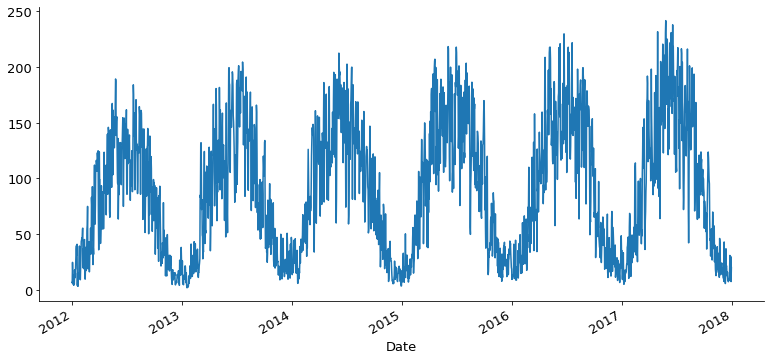

In [38]:
url = 'https://raw.githubusercontent.com/jenfly/opsd/master/opsd_germany_daily.csv'
df = pd.read_csv(url, index_col='Date', parse_dates=True)
s = df.Solar.dropna()
s.plot()

A **seasonal plot** shows each year as a seperate line:

<AxesSubplot:xlabel='Date'>

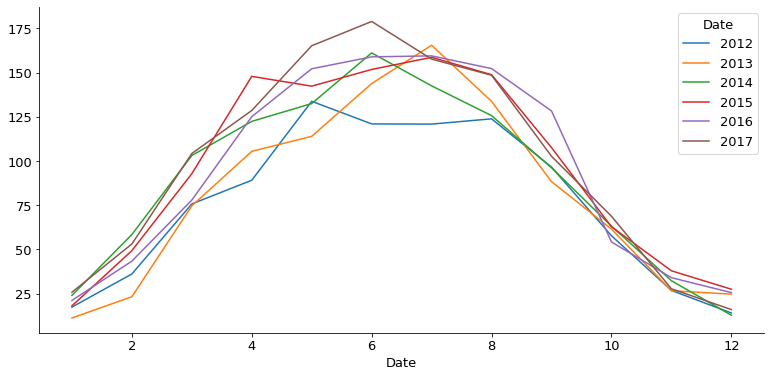

In [39]:
s.groupby([s.index.year, s.index.month]).mean().unstack(0).plot()

A **seasonal subseries plot** shows the year-over-year trend within each month:

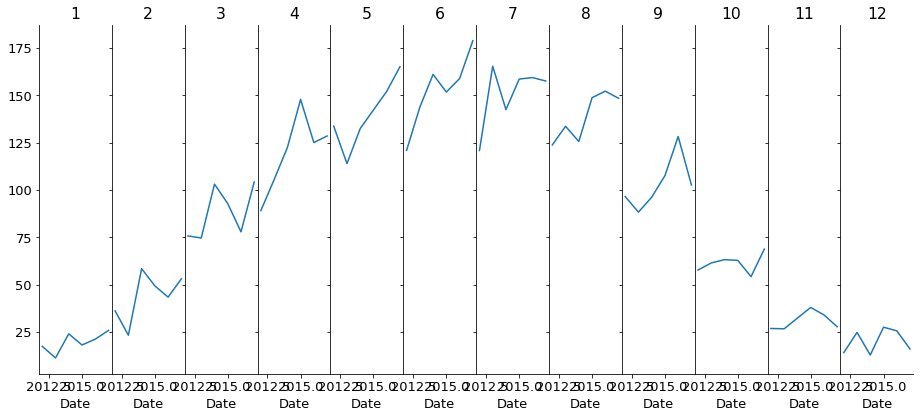

In [40]:
fig, axs = plt.subplots(1, 12, sharex=True, sharey=True)
for ax, (month, x) in zip(axs, s.groupby([s.index.year, s.index.month]).mean().unstack().iteritems()):
    x.plot(ax=ax, title=month)
fig.tight_layout()
fig.subplots_adjust(wspace=0)

## Seasonal Decomposition

In [41]:
import statsmodels.api as sm

# reload our sa temps data
url = "https://gist.githubusercontent.com/ryanorsinger/0ec766c66f4089bdcbc1d4fb294a3394/raw/197c1f0d7b55a45f29437811bc73d9c4ef8af647/sa_temps.csv"
s = pd.read_csv(url, index_col='datetime', parse_dates=True).temp
s = s.dropna()
s = to_fahrenheit(s)
s = s.resample('W').mean()

In [42]:
# using statsmodels
result = sm.tsa.seasonal_decompose(s, model='additive')
result = pd.DataFrame(dict(
    observed=result.observed,
    residual=result.resid,
    seasonal=result.seasonal,
    trend=result.trend
))

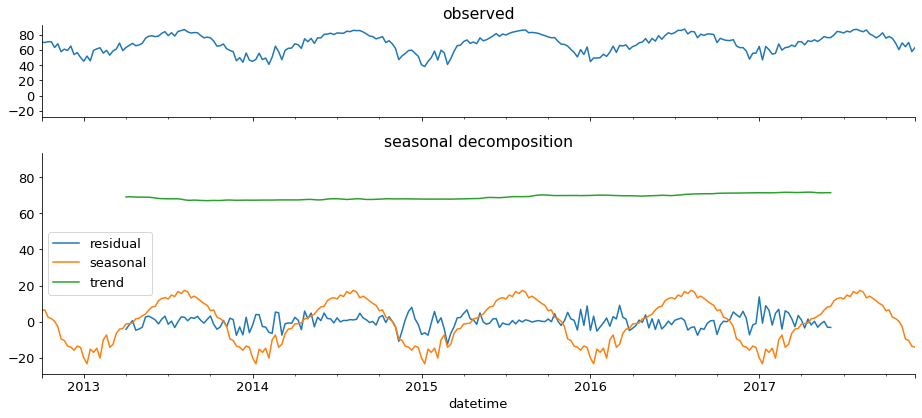

In [43]:
gs = plt.GridSpec(3, 1)
fig = plt.figure()
ax1 = fig.add_subplot(gs[1:])
ax2 = fig.add_subplot(gs[0], sharex=ax1, sharey=ax1)
result.iloc[:, 1:].plot(ax=ax1, title='seasonal decomposition')
result.observed.plot(ax=ax2, title='observed')
fig.tight_layout()

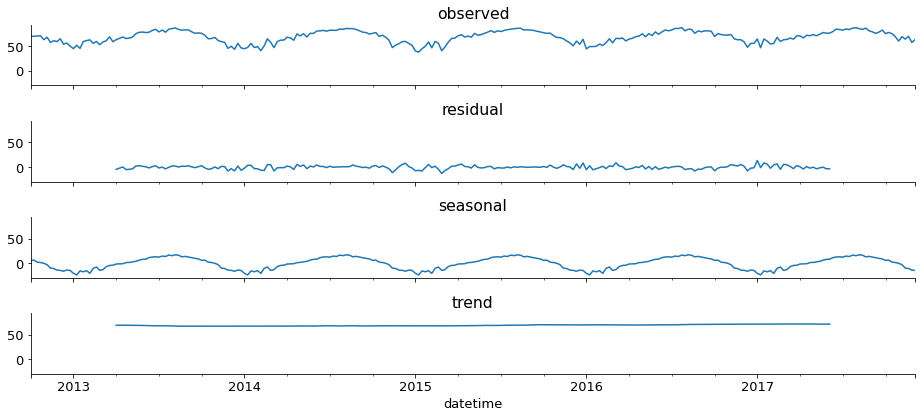

In [44]:
fig, axs = plt.subplots(4, 1, sharex=True, sharey=True)
for ax, (col, x) in zip(axs, result.iteritems()):
    x.plot(ax=ax, title=col)
fig.tight_layout()

What do these look like with synthetic data?

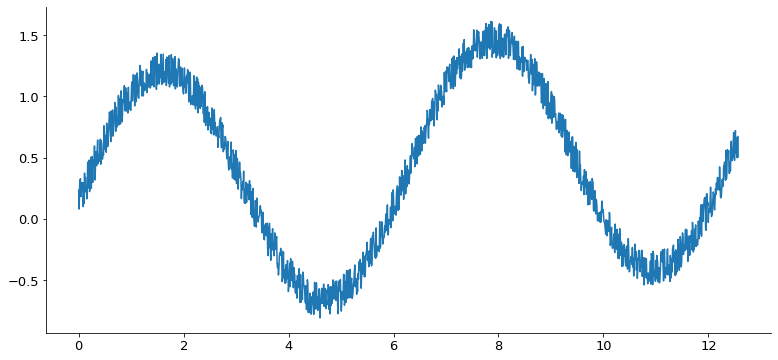

In [45]:
np.random.seed(13)

n = 365 * 4

x = np.linspace(0,4 * np.pi, n)
y = np.sin(x)
y += np.random.rand(n)* .3
y += np.linspace(0,.5,n)

plt.plot(x,y)

In [46]:
np.random.seed(13)
n = 365 * 4
idx = pd.date_range('2016', freq='D', periods=n)
df = pd.DataFrame({
    'trend': np.linspace(0, 2, n),
    'seasonal': np.sin(np.linspace(0, 8*np.pi, n)),
    'noise': np.random.normal(1, .5, n)
}).set_index(idx)
df['combined'] = df.trend + df.seasonal + df.noise

<AxesSubplot:>

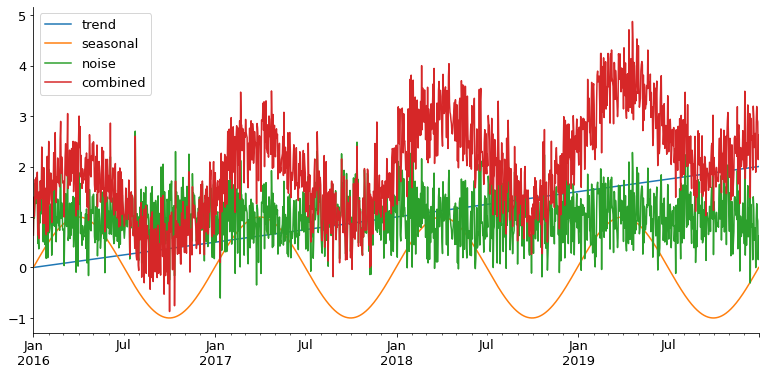

In [47]:
df.plot()

<AxesSubplot:>

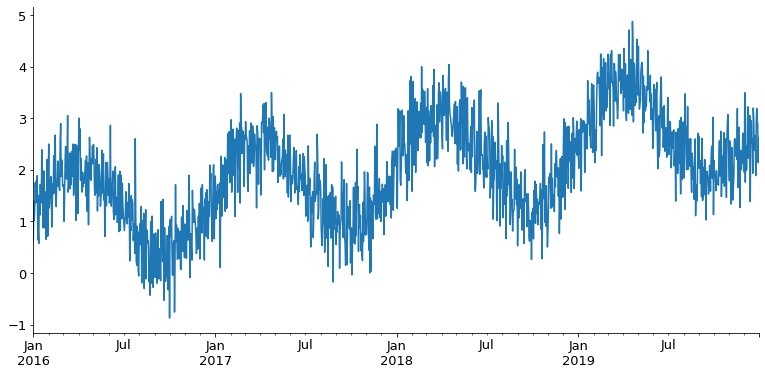

In [48]:
df.combined.plot()

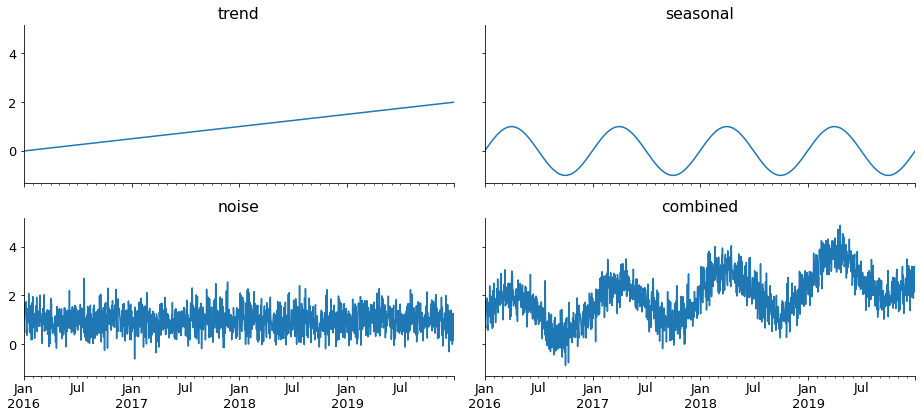

In [49]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
for ax, (col, s) in zip(axs.ravel(), df.iteritems()):
    s.plot(ax=ax, title=col)
fig.tight_layout()

What do our various visuals look like with this data?

# Exercises

In [116]:
df = acquire.get_german_data()

In [117]:
df.head()

,Date,Consumption,Wind,Solar,Wind+Solar
0,2006-01-01,1069.184,NaN,NaN,NaN
1,2006-01-02,1380.521,NaN,NaN,NaN
2,2006-01-03,1442.533,NaN,NaN,NaN
3,2006-01-04,1457.217,NaN,NaN,NaN
4,2006-01-05,1477.131,NaN,NaN,NaN


In [118]:
df = prepare.col_rename(df)

In [119]:
df.head()

,date,consumption,wind,solar,wind_and_solar
0,2006-01-01,1069.184,NaN,NaN,NaN
1,2006-01-02,1380.521,NaN,NaN,NaN
2,2006-01-03,1442.533,NaN,NaN,NaN
3,2006-01-04,1457.217,NaN,NaN,NaN
4,2006-01-05,1477.131,NaN,NaN,NaN


In [120]:
df = df.assign(date=pd.to_datetime(df.date)).sort_values('date').set_index('date')

In [121]:
df.head()

,consumption,wind,solar,wind_and_solar
date,,,,
2006-01-01,1069.184,NaN,NaN,NaN
2006-01-02,1380.521,NaN,NaN,NaN
2006-01-03,1442.533,NaN,NaN,NaN
2006-01-04,1457.217,NaN,NaN,NaN
2006-01-05,1477.131,NaN,NaN,NaN


In [122]:
df['wind_solar_custum'] = df['wind'] + df['solar']

In [123]:
df[df['wind_and_solar'] != (df['wind'] + df['solar'])][['wind', 'solar', 'wind_and_solar', 'wind_solar_custum']]

,wind,solar,wind_and_solar,wind_solar_custum
date,,,,
2006-01-01,NaN,NaN,NaN,NaN
2006-01-02,NaN,NaN,NaN,NaN
2006-01-03,NaN,NaN,NaN,NaN
2006-01-04,NaN,NaN,NaN,NaN
2006-01-05,NaN,NaN,NaN,NaN
...,...,...,...,...
2017-12-25,587.810,15.765,603.575,603.575
2017-12-26,717.453,30.923,748.376,748.376
2017-12-27,394.507,16.530,411.037,411.037


In [124]:
df.fillna(0, inplace = True)

In [125]:
df

,consumption,wind,solar,wind_and_solar,wind_solar_custum
date,,,,,
2006-01-01,1069.18400,0.000,0.000,0.000,0.000
2006-01-02,1380.52100,0.000,0.000,0.000,0.000
2006-01-03,1442.53300,0.000,0.000,0.000,0.000
2006-01-04,1457.21700,0.000,0.000,0.000,0.000
2006-01-05,1477.13100,0.000,0.000,0.000,0.000
...,...,...,...,...,...
2017-12-27,1263.94091,394.507,16.530,411.037,411.037
2017-12-28,1299.86398,506.424,14.162,520.586,520.586
2017-12-29,1295.08753,584.277,29.854,614.131,614.131


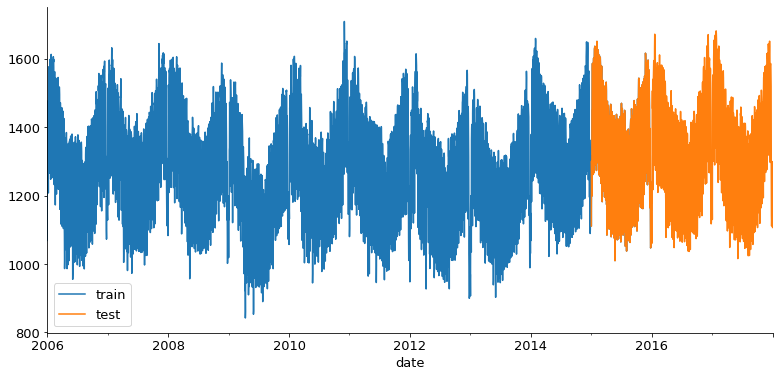

In [126]:
train = df.loc[:'2015']
test = df.loc['2015':]

ax = train.consumption.plot(label='train')
test.consumption.plot(ax=ax, label='test')
plt.legend()

In [127]:
df =train.copy()

In [128]:
df.head()

,consumption,wind,solar,wind_and_solar,wind_solar_custum
date,,,,,
2006-01-01,1069.184,0.0,0.0,0.0,0.0
2006-01-02,1380.521,0.0,0.0,0.0,0.0
2006-01-03,1442.533,0.0,0.0,0.0,0.0
2006-01-04,1457.217,0.0,0.0,0.0,0.0
2006-01-05,1477.131,0.0,0.0,0.0,0.0


In [129]:
consumption_df = df['consumption']

In [130]:
consumption_df

date
2006-01-01    1069.184
2006-01-02    1380.521
2006-01-03    1442.533
2006-01-04    1457.217
2006-01-05    1477.131
                ...   
2015-12-27    1068.214
2015-12-28    1219.075
2015-12-29    1233.660
2015-12-30    1238.863
2015-12-31    1158.103
Name: consumption, Length: 3652, dtype: float64

<AxesSubplot:xlabel='date'>

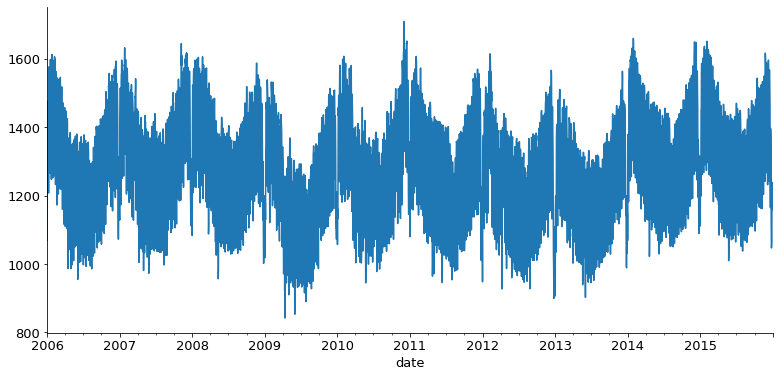

In [131]:
consumption_df.plot()

<AxesSubplot:xlabel='date'>

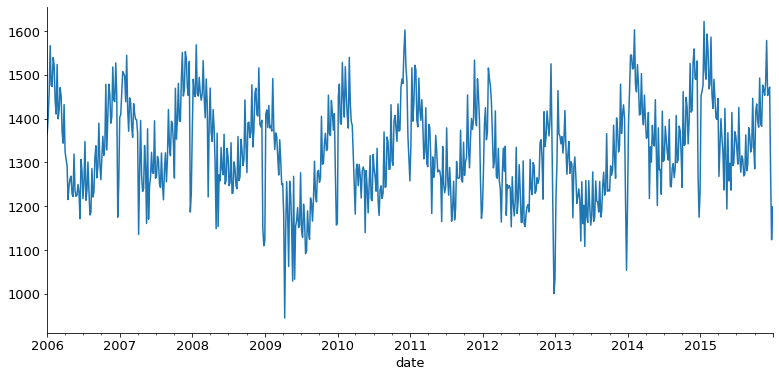

In [132]:
consumption_df.resample('5D').mean().plot()

In [133]:
consumption_df = pd.DataFrame(consumption_df)

In [134]:
consumption_df

,consumption
date,
2006-01-01,1069.184
2006-01-02,1380.521
2006-01-03,1442.533
2006-01-04,1457.217
2006-01-05,1477.131
...,...
2015-12-27,1068.214
2015-12-28,1219.075
2015-12-29,1233.660


In [137]:
consumption_df['yearly_avg'] = consumption_df.resample('Y').mean()
consumption_df['weekly_avg'] = consumption_df.consumption.resample('M').mean()

In [144]:
consumption_df.yearly_avg.value_counts()

1384.286474    1
1259.554597    1
1328.257770    1
1381.273482    1
1360.635197    1
1354.018787    1
1338.599178    1
1339.913797    1
1282.991131    1
1269.416036    1
Name: yearly_avg, dtype: int64

<AxesSubplot:xlabel='date'>

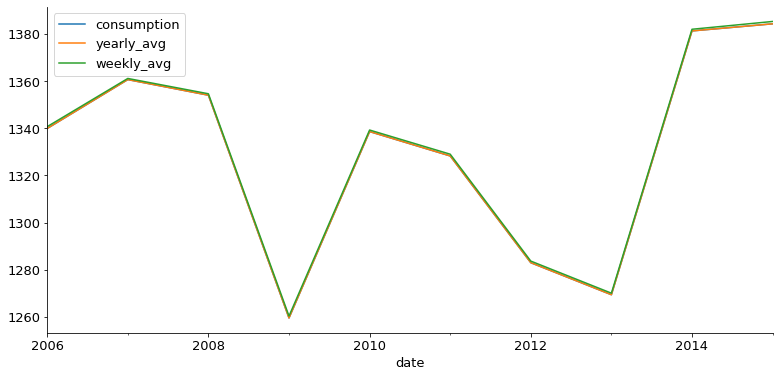

In [146]:
consumption_df.resample('Y').mean().plot()

<AxesSubplot:xlabel='date'>

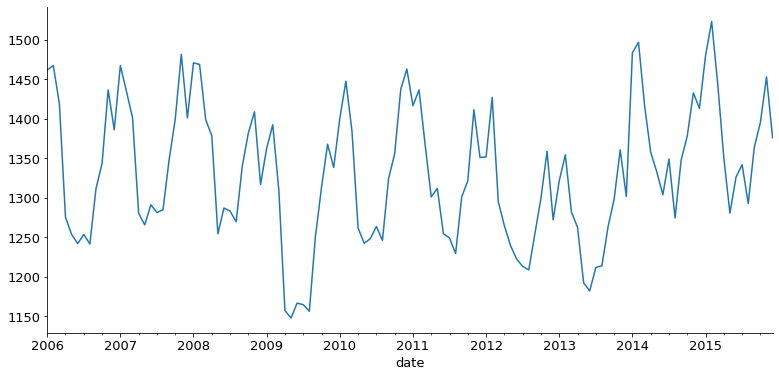

In [148]:
consumption_df.consumption.resample('M').mean().plot()

In [149]:
df = acquire.get_sales_data()

In [150]:
df.head()

,item,store_id,sale_amount,sale_date,sale_id,store_address,store_city,store_state,store_zipcode,item_brand,item_name,item_price,item_upc12,item_upc14
0,1,1,13.0,"Tue, 01 Jan 2013 00:00:00 GMT",1,12125 Alamo Ranch Pkwy,San Antonio,TX,78253,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013
1,1,1,11.0,"Wed, 02 Jan 2013 00:00:00 GMT",2,12125 Alamo Ranch Pkwy,San Antonio,TX,78253,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013
2,1,1,14.0,"Thu, 03 Jan 2013 00:00:00 GMT",3,12125 Alamo Ranch Pkwy,San Antonio,TX,78253,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013
3,1,1,13.0,"Fri, 04 Jan 2013 00:00:00 GMT",4,12125 Alamo Ranch Pkwy,San Antonio,TX,78253,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013
4,1,1,10.0,"Sat, 05 Jan 2013 00:00:00 GMT",5,12125 Alamo Ranch Pkwy,San Antonio,TX,78253,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013


In [152]:
df = prepare.prep_store_data(df)

In [167]:
df.head(30)

,item,store_id,sale_amount,sale_id,store_address,store_city,store_state,store_zipcode,item_brand,item_name,item_price,item_upc12,item_upc14
sale_date,,,,,,,,,,,,,
2013-01-01 00:00:00+00:00,1,1,13.0,1,12125 Alamo Ranch Pkwy,San Antonio,TX,78253,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013
2013-01-01 00:00:00+00:00,12,7,26.0,211817,12018 Perrin Beitel Rd,San Antonio,TX,78217,Mueller,Mueller Sport Care Basic Support Level Medium ...,8.40,74676640211,74676640211
2013-01-01 00:00:00+00:00,46,7,27.0,832657,12018 Perrin Beitel Rd,San Antonio,TX,78217,Mama Marys,Pizza Sauce,4.65,35457770664,35457770664
2013-01-01 00:00:00+00:00,12,8,54.0,213643,15000 San Pedro Ave,San Antonio,TX,78232,Mueller,Mueller Sport Care Basic Support Level Medium ...,8.40,74676640211,74676640211
2013-01-01 00:00:00+00:00,12,9,35.0,215469,735 SW Military Dr,San Antonio,TX,78221,Mueller,Mueller Sport Care Basic Support Level Medium ...,8.40,74676640211,74676640211
2013-01-01 00:00:00+00:00,12,10,41.0,217295,8503 NW Military Hwy,San Antonio,TX,78231,Mueller,Mueller Sport Care Basic Support Level Medium ...,8.40,74676640211,74676640211
2013-01-01 00:00:00+00:00,46,6,23.0,830831,1015 S WW White Rd,San Antonio,TX,78220,Mama Marys,Pizza Sauce,4.65,35457770664,35457770664
2013-01-01 00:00:00+00:00,13,1,37.0,219121,12125 Alamo Ranch Pkwy,San Antonio,TX,78253,Garnier Nutritioniste,Garnier Nutritioniste Moisture Rescue Fresh Cl...,6.47,603084234561,603084234561
2013-01-01 00:00:00+00:00,13,2,51.0,220947,9255 FM 471 West,San Antonio,TX,78251,Garnier Nutritioniste,Garnier Nutritioniste Moisture Rescue Fresh Cl...,6.47,603084234561,603084234561


In [154]:
item_1_df = df[df.item == 1]

<AxesSubplot:xlabel='sale_date'>

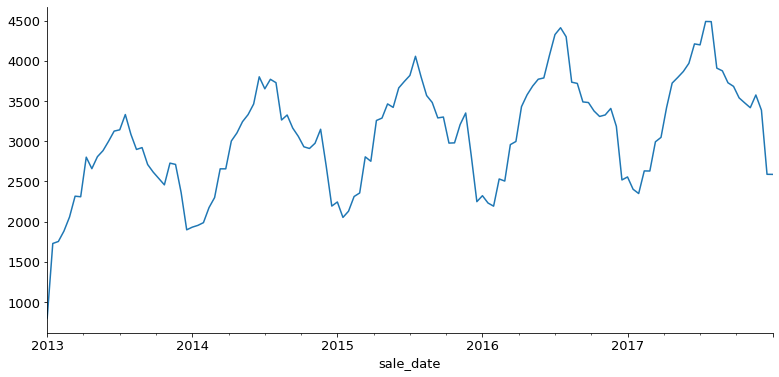

In [162]:
item_1_df.sale_amount.resample('2W').sum().plot()

In [173]:
item_1_df.sale_amount.resample('1Y').sum().pct_change()

sale_date
2013-12-31 00:00:00+00:00         NaN
2014-12-31 00:00:00+00:00    0.150683
2015-12-31 00:00:00+00:00    0.048582
2016-12-31 00:00:00+00:00    0.083434
2017-12-31 00:00:00+00:00    0.033580
Freq: A-DEC, Name: sale_amount, dtype: float64

In [168]:
item_45_df = df[df.item == 45]

<AxesSubplot:xlabel='sale_date'>

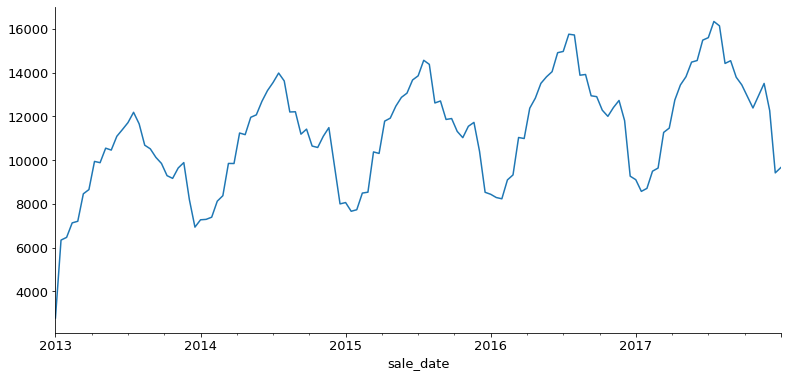

In [169]:
item_45_df.sale_amount.resample('2W').sum().plot()

In [176]:
item_45_df.sale_amount.resample('3M').sum().pct_change()

sale_date
2013-01-31 00:00:00+00:00         NaN
2013-04-30 00:00:00+00:00    2.894256
2013-07-31 00:00:00+00:00    0.377679
2013-10-31 00:00:00+00:00   -0.124811
2014-01-31 00:00:00+00:00   -0.190300
2014-04-30 00:00:00+00:00    0.173045
2014-07-31 00:00:00+00:00    0.385767
2014-10-31 00:00:00+00:00   -0.131064
2015-01-31 00:00:00+00:00   -0.202530
2015-04-30 00:00:00+00:00    0.093882
2015-07-31 00:00:00+00:00    0.376412
2015-10-31 00:00:00+00:00   -0.128743
2016-01-31 00:00:00+00:00   -0.199181
2016-04-30 00:00:00+00:00    0.136073
2016-07-31 00:00:00+00:00    0.368158
2016-10-31 00:00:00+00:00   -0.131841
2017-01-31 00:00:00+00:00   -0.204924
2017-04-30 00:00:00+00:00    0.098786
2017-07-31 00:00:00+00:00    0.362981
2017-10-31 00:00:00+00:00   -0.120309
2018-01-31 00:00:00+00:00   -0.436095
Freq: 3M, Name: sale_amount, dtype: float64

In [174]:
df.sale_amount.resample('1Y').sum().pct_change()

sale_date
2013-12-31 00:00:00+00:00         NaN
2014-12-31 00:00:00+00:00    0.150384
2015-12-31 00:00:00+00:00    0.043939
2016-12-31 00:00:00+00:00    0.086011
2017-12-31 00:00:00+00:00    0.036359
Freq: A-DEC, Name: sale_amount, dtype: float64

In [180]:
df.head()

,item,store_id,sale_amount,sale_id,store_address,store_city,store_state,store_zipcode,item_brand,item_name,item_price,item_upc12,item_upc14
sale_date,,,,,,,,,,,,,
2013-01-01 00:00:00+00:00,1,1,13.0,1,12125 Alamo Ranch Pkwy,San Antonio,TX,78253,Riceland,Riceland American Jazmine Rice,0.84,35200264013,35200264013
2013-01-01 00:00:00+00:00,12,7,26.0,211817,12018 Perrin Beitel Rd,San Antonio,TX,78217,Mueller,Mueller Sport Care Basic Support Level Medium ...,8.40,74676640211,74676640211
2013-01-01 00:00:00+00:00,46,7,27.0,832657,12018 Perrin Beitel Rd,San Antonio,TX,78217,Mama Marys,Pizza Sauce,4.65,35457770664,35457770664
2013-01-01 00:00:00+00:00,12,8,54.0,213643,15000 San Pedro Ave,San Antonio,TX,78232,Mueller,Mueller Sport Care Basic Support Level Medium ...,8.40,74676640211,74676640211
2013-01-01 00:00:00+00:00,12,9,35.0,215469,735 SW Military Dr,San Antonio,TX,78221,Mueller,Mueller Sport Care Basic Support Level Medium ...,8.40,74676640211,74676640211


In [205]:
df['sales_total'] = df.sale_amount * df.item_price

item name: Riceland
item name: Riceland American Jazmine Rice
________________________________________________
sale_date
2013-12-31 00:00:00+00:00         NaN
2014-12-31 00:00:00+00:00    0.150683
2015-12-31 00:00:00+00:00    0.048582
2016-12-31 00:00:00+00:00    0.083434
2017-12-31 00:00:00+00:00    0.033580
Freq: A-DEC, Name: sale_amount, dtype: float64
_________________________________________________
item name: Caress
item name: Caress Velvet Bliss Ultra Silkening Beauty Bar - 6 Ct
________________________________________________
sale_date
2013-12-31 00:00:00+00:00         NaN
2014-12-31 00:00:00+00:00    0.149992
2015-12-31 00:00:00+00:00    0.043890
2016-12-31 00:00:00+00:00    0.087194
2017-12-31 00:00:00+00:00    0.034336
Freq: A-DEC, Name: sale_amount, dtype: float64
_________________________________________________
item name: Earths Best
item name: Earths Best Organic Fruit Yogurt Smoothie Mixed Berry
________________________________________________
sale_date
2013-12-31 00:00

item name: Doctors Best
item name: Doctors Best Best Curcumin C3 Complex 1000mg Tablets - 120 Ct
________________________________________________
sale_date
2013-12-31 00:00:00+00:00         NaN
2014-12-31 00:00:00+00:00    0.144098
2015-12-31 00:00:00+00:00    0.042184
2016-12-31 00:00:00+00:00    0.088747
2017-12-31 00:00:00+00:00    0.036783
Freq: A-DEC, Name: sale_amount, dtype: float64
_________________________________________________
item name: Betty Crocker
item name: Betty Crocker Twin Pack Real Potatoes Scalloped 2 Pouches For 2 Meals - 2 Pk
________________________________________________
sale_date
2013-12-31 00:00:00+00:00         NaN
2014-12-31 00:00:00+00:00    0.148897
2015-12-31 00:00:00+00:00    0.043220
2016-12-31 00:00:00+00:00    0.087536
2017-12-31 00:00:00+00:00    0.032480
Freq: A-DEC, Name: sale_amount, dtype: float64
_________________________________________________
item name: Reese
item name: Reese Mandarin Oranges Segments In Light Syrup
_______________________

item name: Elmers
item name: Elmers Board Mate Dual Tip Glue Pen
________________________________________________
sale_date
2013-12-31 00:00:00+00:00         NaN
2014-12-31 00:00:00+00:00    0.145765
2015-12-31 00:00:00+00:00    0.043447
2016-12-31 00:00:00+00:00    0.084749
2017-12-31 00:00:00+00:00    0.035370
Freq: A-DEC, Name: sale_amount, dtype: float64
_________________________________________________
item name: Kelloggs
item name: Kelloggs Disney Pixar Cars 2 Cereal
________________________________________________
sale_date
2013-12-31 00:00:00+00:00         NaN
2014-12-31 00:00:00+00:00    0.149672
2015-12-31 00:00:00+00:00    0.045848
2016-12-31 00:00:00+00:00    0.085141
2017-12-31 00:00:00+00:00    0.039033
Freq: A-DEC, Name: sale_amount, dtype: float64
_________________________________________________
item name: Mama Marys
item name: Pizza Sauce
________________________________________________
sale_date
2013-12-31 00:00:00+00:00         NaN
2014-12-31 00:00:00+00:00    0.145

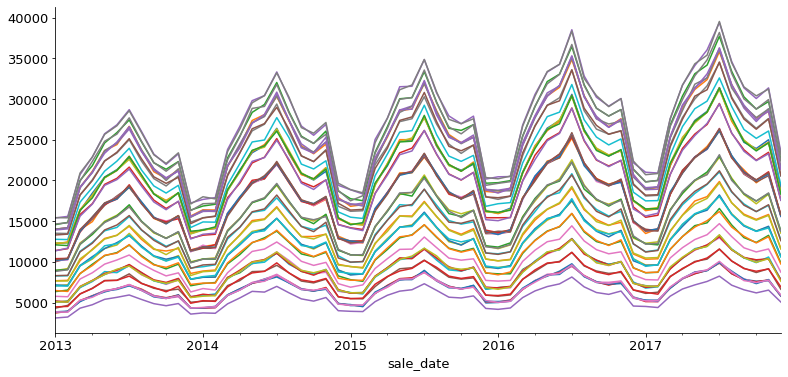

In [215]:
for i in range(1,50):
    item_df = df[df.item == i]
    item_df.sale_amount.resample('1M').sum().plot()
    print(f'item name: {item_df.item_brand[i]}')
    print(f'item name: {item_df.item_name[i]}')
    print(f'________________________________________________')
    print(item_df.sale_amount.resample('1Y').sum().pct_change())
    print('_________________________________________________')

In [ ]:
for i in range(1,50):
    item_df = df[df.item == i]
    item_df.sale_amount.resample('1W').mean().plot()
    print(f'item name: {item_df.item_brand[i]}')
    print(f'item name: {item_df.item_name[i]}')
    print(f'________________________________________________')
    print(item_df.sale_amount.resample('1Y').sum().pct_change())
    print('_________________________________________________')

item name: Riceland
item name: Riceland American Jazmine Rice
________________________________________________
sale_date
2013-12-31 00:00:00+00:00         NaN
2014-12-31 00:00:00+00:00    0.150683
2015-12-31 00:00:00+00:00    0.048582
2016-12-31 00:00:00+00:00    0.083434
2017-12-31 00:00:00+00:00    0.033580
Freq: A-DEC, Name: sale_amount, dtype: float64
_________________________________________________
item name: Caress
item name: Caress Velvet Bliss Ultra Silkening Beauty Bar - 6 Ct
________________________________________________
sale_date
2013-12-31 00:00:00+00:00         NaN
2014-12-31 00:00:00+00:00    0.149992
2015-12-31 00:00:00+00:00    0.043890
2016-12-31 00:00:00+00:00    0.087194
2017-12-31 00:00:00+00:00    0.034336
Freq: A-DEC, Name: sale_amount, dtype: float64
_________________________________________________
item name: Earths Best
item name: Earths Best Organic Fruit Yogurt Smoothie Mixed Berry
________________________________________________
sale_date
2013-12-31 00:00

item name: Doctors Best
item name: Doctors Best Best Curcumin C3 Complex 1000mg Tablets - 120 Ct
________________________________________________
sale_date
2013-12-31 00:00:00+00:00         NaN
2014-12-31 00:00:00+00:00    0.144098
2015-12-31 00:00:00+00:00    0.042184
2016-12-31 00:00:00+00:00    0.088747
2017-12-31 00:00:00+00:00    0.036783
Freq: A-DEC, Name: sale_amount, dtype: float64
_________________________________________________
item name: Betty Crocker
item name: Betty Crocker Twin Pack Real Potatoes Scalloped 2 Pouches For 2 Meals - 2 Pk
________________________________________________
sale_date
2013-12-31 00:00:00+00:00         NaN
2014-12-31 00:00:00+00:00    0.148897
2015-12-31 00:00:00+00:00    0.043220
2016-12-31 00:00:00+00:00    0.087536
2017-12-31 00:00:00+00:00    0.032480
Freq: A-DEC, Name: sale_amount, dtype: float64
_________________________________________________
item name: Reese
item name: Reese Mandarin Oranges Segments In Light Syrup
_______________________

sale_date
2013-12-31 00:00:00+00:00         NaN
2014-12-31 00:00:00+00:00    0.150693
2015-12-31 00:00:00+00:00    0.046793
2016-12-31 00:00:00+00:00    0.080797
2017-12-31 00:00:00+00:00    0.033026
Freq: A-DEC, Name: sale_amount, dtype: float64
_________________________________________________
item name: Ferrara
item name: Ferrara Vanilla Syrup
________________________________________________
sale_date
2013-12-31 00:00:00+00:00         NaN
2014-12-31 00:00:00+00:00    0.146394
2015-12-31 00:00:00+00:00    0.044490
2016-12-31 00:00:00+00:00    0.086558
2017-12-31 00:00:00+00:00    0.039767
Freq: A-DEC, Name: sale_amount, dtype: float64
_________________________________________________
item name: Elmers
item name: Elmers Board Mate Dual Tip Glue Pen
________________________________________________
sale_date
2013-12-31 00:00:00+00:00         NaN
2014-12-31 00:00:00+00:00    0.145765
2015-12-31 00:00:00+00:00    0.043447
2016-12-31 00:00:00+00:00    0.084749
2017-12-31 00:00:00+00:00    

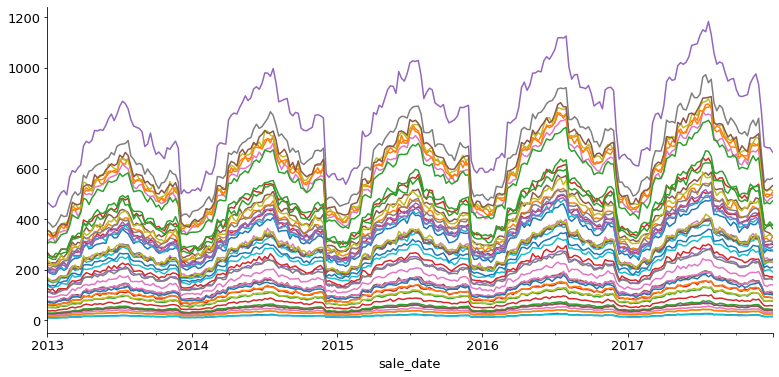

In [206]:
for i in range(1,50):
    item_df = df[df.item == i]
    item_df.sales_total.resample('1W').mean().plot()
    print(f'item name: {item_df.item_brand[i]}')
    print(f'item name: {item_df.item_name[i]}')
    print(f'________________________________________________')
    print(item_df.sale_amount.resample('1Y').sum().pct_change())
    print('_________________________________________________')

item name: Riceland
item name: Riceland American Jazmine Rice
________________________________________________
sale_date
2013-12-31 00:00:00+00:00         NaN
2014-12-31 00:00:00+00:00    0.150683
2015-12-31 00:00:00+00:00    0.048582
2016-12-31 00:00:00+00:00    0.083434
2017-12-31 00:00:00+00:00    0.033580
Freq: A-DEC, Name: sale_amount, dtype: float64
_________________________________________________
item name: Caress
item name: Caress Velvet Bliss Ultra Silkening Beauty Bar - 6 Ct
________________________________________________
sale_date
2013-12-31 00:00:00+00:00         NaN
2014-12-31 00:00:00+00:00    0.149992
2015-12-31 00:00:00+00:00    0.043890
2016-12-31 00:00:00+00:00    0.087194
2017-12-31 00:00:00+00:00    0.034336
Freq: A-DEC, Name: sale_amount, dtype: float64
_________________________________________________
item name: Earths Best
item name: Earths Best Organic Fruit Yogurt Smoothie Mixed Berry
________________________________________________
sale_date
2013-12-31 00:00

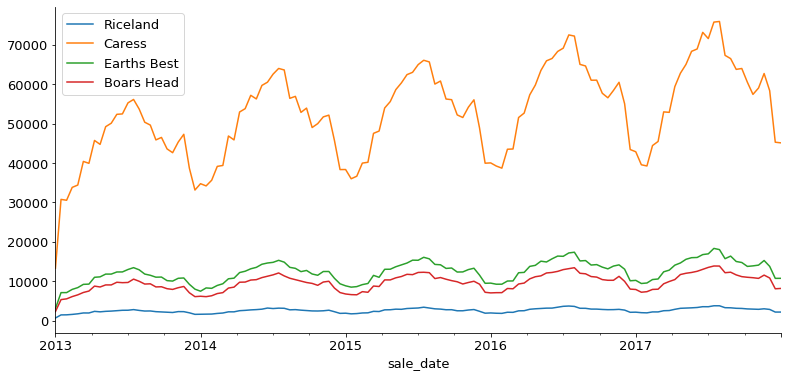

In [210]:
for i in range(1,5):
    item_df = df[df.item == i]
    item_df.sales_total.resample('2W').sum().plot(label = item_df.item_brand[i])
    plt.legend()
    print(f'item name: {item_df.item_brand[i]}')
    print(f'item name: {item_df.item_name[i]}')
    print(f'________________________________________________')
    print(item_df.sale_amount.resample('1Y').sum().pct_change())
    print('_________________________________________________')

item name: Back To Nature
item name: Back To Nature Gluten Free White Cheddar Rice Thin Crackers
________________________________________________
sale_date
2013-12-31 00:00:00+00:00         NaN
2014-12-31 00:00:00+00:00    0.148289
2015-12-31 00:00:00+00:00    0.047300
2016-12-31 00:00:00+00:00    0.091987
2017-12-31 00:00:00+00:00    0.037841
Freq: A-DEC, Name: sale_amount, dtype: float64
_________________________________________________
item name: Sally Hansen
item name: Sally Hansen Nail Color Magnetic 903 Silver Elements
________________________________________________
sale_date
2013-12-31 00:00:00+00:00         NaN
2014-12-31 00:00:00+00:00    0.149965
2015-12-31 00:00:00+00:00    0.040836
2016-12-31 00:00:00+00:00    0.091013
2017-12-31 00:00:00+00:00    0.032335
Freq: A-DEC, Name: sale_amount, dtype: float64
_________________________________________________
item name: Twinings Of London
item name: Twinings Of London Classics Lady Grey Tea - 20 Ct
________________________________

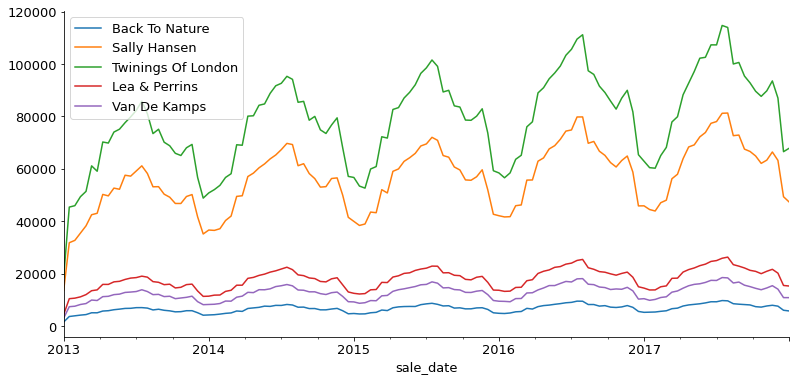

In [211]:
for i in range(5,10):
    item_df = df[df.item == i]
    item_df.sales_total.resample('2W').sum().plot(label = item_df.item_brand[i])
    plt.legend()
    print(f'item name: {item_df.item_brand[i]}')
    print(f'item name: {item_df.item_name[i]}')
    print(f'________________________________________________')
    print(item_df.sale_amount.resample('1Y').sum().pct_change())
    print('_________________________________________________')